# SN2023ixf with J-VAR (v1)

In this Jupyter notebook, we will create the necessary code to study SN2023ixf as collected in J-VAR.

In [1]:
# Ejecution Time
import time
a = time.time()

# Packages
from astropy import coordinates as coords
from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.time import Time
from astroquery.sdss import SDSS as sdss
import astropy.units as u
import corner
from datetime import datetime, timedelta
import glob
from IPython.display import display, Math
import iminuit
import jdcal
from lmfit import Model, Parameters
import matplotlib.pyplot as plt
import numdifftools
import numpy as np
import pandas as pd
from scipy import stats
import smplotlib
import sncosmo
from tqdm import tqdm as tqdm

J-VAR is a project from OAJ aimed at finding variable sources. To achieve this, they observe a sky field 11 times, taking 3 sets of images with 7 different filters for each field. Instead of pointing at luminous objects, they survey the sky looking for variable or new sources. Therefore, to search for SN2023ixf, we should look in regions near the M101 galaxy, specifically at $\alpha$ = 210.91083$\,$deg and $\delta$ = 54.311694$\,$deg. \
This search will be based on selecting the sky regions within 2$\,$arcsec of the SN2023ixf coordinates. Then, we will examine the magnitude values to see if we have detected the light curve. Note that the magnitudes collected in J-VAR are instrumental magnitudes, that is to say, that are affected by atmosphere extinction. Therefore, we should correct them by doing a match between the J-VAR catalogue and the SDSS (for example) catalogue to calculate the offset. 

## 1. Offset

First, we should estimate the magnitude offset before starting to calculate the light curve. We should download a catalogue (e.g.: SDSS) to match it with J-VAR catalogues. In this way, we will much just the catalogues and see the offset (difference in magnitude between the stars in J-VAR (`JVAR`) and SDSS (`SDSS`) to know the extinction effect. 

### 1.1. J-VAR catalog

First, we introduce the J-VAR data from the field in which SN2023ixf is collected in `JVAR` by grouping all the _.fits_ in `file_list`.

In [2]:
# Paths (concatenate all sets (fields) of data
directory_path = '/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/JVAR/gSDSS/catalogues/'
file_pattern = directory_path + 'j02-*-01_proc.proccat'
file_list = sorted(glob.glob(file_pattern))

In [3]:
# J-VAR data
JVAR = []

# Read each FITS data (field)
for file_path in tqdm(file_list):
    with fits.open(file_path, memmap=True) as hdul:
        
        gsdss_data = Table(hdul[2].data)
        JVAR.append(gsdss_data)

JVAR = vstack(JVAR)

# Remove all data of SN2023ixf from JVAR (to avoid wrong offsets)
alpha_min = 210.91 - 0.3
alpha_max = 210.91 + 0.3
delta_min = 54.31 - 0.2
delta_max = 54.31 + 0.2

mask = ~((JVAR['ALPHA_J2000'] >= alpha_min) & 
         (JVAR['ALPHA_J2000'] <= alpha_max) &
         (JVAR['DELTA_J2000'] >= delta_min) &
         (JVAR['DELTA_J2000'] <= delta_max))

JVAR_filtered = JVAR[mask]
JVAR

100%|███████████████████████████████████████████| 82/82 [00:11<00:00,  7.34it/s]


NUMBER,X_IMAGE,Y_IMAGE,THETA_WORLD,ERRTHETA_WORLD,A_IMAGE,B_IMAGE,ERRA_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETA_IMAGE,FLUX_AUTO,FLUXERR_AUTO,ALPHA_J2000,DELTA_J2000,X_WORLD,Y_WORLD,MAG_AUTO,MAG_BEST,MAGERR_AUTO,MAGERR_BEST,FLUX_MAX,FWHM_IMAGE,FLAGS,ELLIPTICITY,MU_THRESHOLD,THRESHOLD,BACKGROUND,FLUX_RADIUS,ISOAREA_IMAGE,CLASS_STAR,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,MU_MAX,KRON_RADIUS,A_WORLD,B_WORLD,ERRA_WORLD,ERRB_WORLD,ISOAREA_WORLD,FLUX_PETRO,FLUXERR_PETRO,PETRO_RADIUS,FWHM_WORLD,XWIN_IMAGE,YWIN_IMAGE,SNR_WIN,FLAGS_WIN,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_WORLD,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,XWIN_WORLD,YWIN_WORLD,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_WORLD,MAG_APER,MAGERR_APER,FLUX_APER,FLUXERR_APER,FLAGS_WEIGHT,OBSDATE
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32[20],float32[20],float32[20],float32[20],int16,float64
1,1624.0778,53.91845,-3.028241,-22.221987,1.5358592,1.4818074,0.024804754,0.02406105,2.7745166,-19.629786,27550.455,345.9384,210.36550703338037,53.40238884810943,210.36550703338037,53.40238884810943,13.899678,13.899678,0.013636402,0.013636402,3190.6943,2.3602972,16,0.035193264,19.547794,47.50097,1.2817965,1.5257541,52,0.9703275,26817.082,309.46146,13.928971,0.012532129,27756.717,342.26678,13.89158,0.013391416,14.964098,3.5,0.00023606193,0.00022685931,3.820218e-06,3.6758925e-06,1.2385764e-06,27996.03,424.2552,4.62,0.00036427254,1624.0930159550026,53.921743736672774,109.39805,0,0.8785203,0.86281747,12.655524,0.015314263,0.015219079,36.418423,210.3655109593077,53.402389347339536,0.00013462936,0.00013249184,2.3489144e-06,2.3348607e-06,-8.823689,13.903418 .. 13.86379,0.013809707 .. 0.051017262,27455.727 .. 28476.34,349.1303 .. 1337.7393,0,2022.435058130783
2,2294.2908,47.821106,57.222538,58.10458,1.116401,0.9497218,0.095522895,0.07766578,57.594112,58.369343,2616.9463,209.73209,210.5384226691724,53.4011577667147,210.5384226691724,53.4011577667147,16.455513,16.455513,0.08703619,0.08703619,375.51987,2.415356,16,0.14930046,19.534784,47.50097,0.04905656,1.4370527,14,0.95710933,2090.6238,142.39764,16.69931,0.07397019,2632.5264,221.78525,16.449068,0.0914934,17.28723,3.5,0.00017081655,0.00014640905,1.4615892e-05,1.1974146e-05,3.3346288e-07,2439.528,311.29892,5.2799997,0.00037276992,2294.2838758775906,47.84008583355505,17.540543,0,0.8484272,0.77958846,63.025707,0.100601055,0.09997519,75.8146,210.53842086666006,53.40116067808372,0.00012978705,0.000120178636,1.5422838e-05,1.5375346e-05,-50.787937,16.513577 .. 16.793514,0.1355991 .. 0.75243974,2480.6738 .. 1916.8759,309.73953 .. 1328.1156,0,2022.435058130783
3,3284.3887,30.980616,-32.211372,-43.656647,0.9089387,0.7622795,0.04280961,0.037600487,-32.70067,-44.804165,3557.001,176.34052,210.7942299577312,53.397846173896184,210.7942299577312,53.397846173896184,16.12229,16.12229,0.05383912,0.05383912,1548.9175,1.4541637,16,0.16135216,19.541729,47.50097,0.44493556,0.7278829,8,0.91640913,3616.3884,134.05902,16.104313,0.04025787,3853.2173,158.60687,16.03544,0.044702142,15.74874,3.5,0.00014008573,0.00011679522,6.590487e-06,5.7680977e-06,1.9055021e-07,3557.001,176.34052,3.5,0.00022442592,3284.2383830827343,31.00730437863295,37.65585,0,0.45544568,0.2498944,-16.49891,0.025917692,0.020564979,-2.4381046,210.7941910957818,53.39785040132391,7.0248934e-05,3.8214162e-05,3.9958077e-06,3.1507059e-06,-3.026259,16.291132 .. 16.083775,0.11087572 .. 0.3916245,3044.7173 .. 3685.4448,310.85196 .. 1329.0153,0,2022.435058130783
4,3677.991,1

Note that `JVAR` collects all de J-VAR data in the region of the SN2023ixf while `JVAR_filtered` does the same but omits the nearest data point to the SN2023, to avoid counting them to calculate the offset (SN are variable sources). 

To understand better the field/region we are studying, we plot it by using declination and right ascension (equatorial coordinates). 

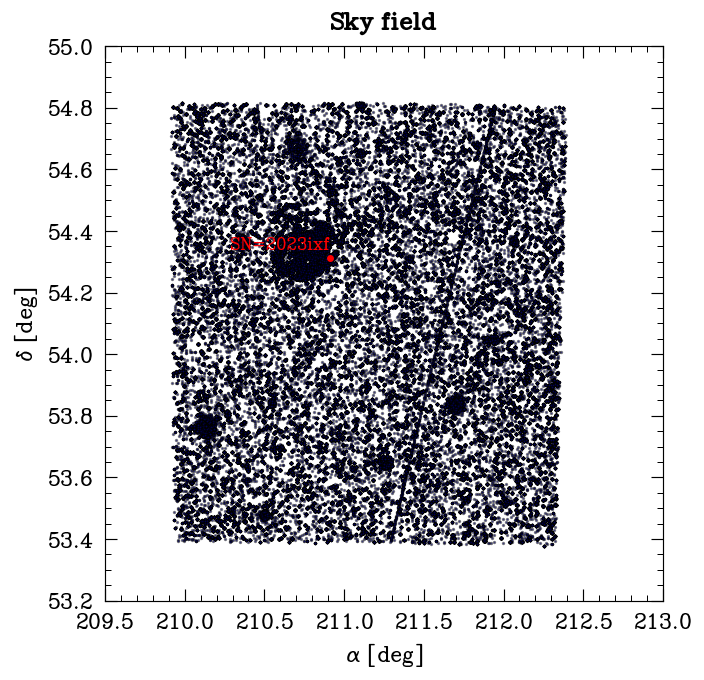

In [4]:
# JVAR region
alpha_JVAR = []
delta_JVAR = []

for i in range(len(JVAR['ALPHA_J2000'])):
    alpha_JVAR.append(JVAR['ALPHA_J2000'][i])
    delta_JVAR.append(JVAR['DELTA_J2000'][i])

# Sky Field
plt.scatter(alpha_JVAR, delta_JVAR, s=1, alpha=0.5, c='blue')

plt.scatter(210.9107, 54.3116, color='red', s=10)
plt.text(210.91, 54.34, 'SN=2023ixf', color='red', fontsize=12, ha='right')


plt.title('Sky field', fontweight='bold')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')
plt.xlim(209.5,213)
plt.ylim(53.2,55)

plt.show()

### 1.2. SDSS catalogue

Now, we extract data from SDSS collected near the region of the SN2023ixf (last plot) in the variable `SDSS`. To do this, we apply the `astropy.query` package.

In [5]:
# SDSS catalogue
co = coords.SkyCoord('14h03m38.580s +54d18m42.10s')
SDSS = sdss.query_region(co, radius='3d', photoobj_fields=['ra', 'dec', 'g', 'err_g', 'r', 'err_r', 'i', 'err_i']) # 1d = 1 degree radius around co

# Remove all data of SN2023ixf from SDSS (to avoid wrong offsets)
alpha_min = alpha_min; alpha_max = alpha_max
delta_min = delta_min; delta_max = delta_max

mask = ~((SDSS['ra'] >= alpha_min) & (SDSS['ra'] <= alpha_max) &
         (SDSS['dec'] >= delta_min) & (SDSS['dec'] <= delta_max))

SDSS_filtered = SDSS[mask]
SDSS

ra,dec,g,err_g,r,err_r,i,err_i
float64,float64,float64,float64,float64,float64,float64,float64
208.666744684062,51.3596409690547,23.28721,0.4919777,21.47353,0.1391869,21.49095,0.2005574
208.453222116138,51.3311737363908,21.94966,0.08293803,20.54697,0.03306065,19.10814,0.01494935
208.274092710626,51.4518954234713,22.64958,0.1501479,21.75642,0.08684612,20.4239,0.03999271
208.056453544559,51.4139809098671,23.2238,0.3145075,21.86554,0.1358559,20.77631,0.08747178
208.870660320016,51.690294595761,22.94862,0.20035,22.36669,0.1790774,21.88567,0.148793
208.782134762079,51.8252306639293,21.99865,0.1098841,20.52483,0.04408089,19.99879,0.03739316
...,...,...,...,...,...,...,...
213.723634164756,52.0448065679407,22.80021,0.2072254,23.11287,0.4391245,22.13022,0.2878339
213.740912227479,51.9397061761997,22.83899,0.2451087,22.73412,0.3723085,21.20583,0.1514824


### 1.3. Match

Lastly, we are going to do the match between the SDSS catalogue (`SDSS`) and J-VAR (`JVAR`) to calculate the offset. Notice that `SDSS_filtered` and `JVAR_filtered` collect the SDSS and JVAR data respectively, by omitting the points near SN2023ixf to avoid wrong calculated offsets. `SDSS_JVAR_filtered` collect the match between SDSS and JVAR by filtering SN2023ixf data points. 

In [6]:
# Coordenates of SDSS
coords_sdss = coords.SkyCoord(ra=SDSS_filtered['ra'] * u.deg, dec=SDSS_filtered['dec'] * u.deg)

# Coordenates of JVAR
coords_jvar = coords.SkyCoord(ra=JVAR_filtered['ALPHA_J2000'] * u.deg, dec=JVAR_filtered['DELTA_J2000'] * u.deg)

idx, d2d, d3d = coords.match_coordinates_sky(coords_sdss, coords_jvar)

# Add the corresponding data from JVAR to SDSS
SDSS_JVAR = SDSS_filtered.copy()
SDSS_JVAR['ALPHA_J2000'] = JVAR_filtered['ALPHA_J2000'][idx]
SDSS_JVAR['DELTA_J2000'] = JVAR_filtered['DELTA_J2000'][idx]
SDSS_JVAR['MAG_BEST'] = JVAR_filtered['MAG_BEST'][idx]
SDSS_JVAR['MAGERR_BEST'] = JVAR_filtered['MAGERR_BEST'][idx]
SDSS_JVAR['MAG_APER'] = JVAR_filtered['MAG_APER'][idx]
SDSS_JVAR['MAGERR_APER'] = JVAR_filtered['MAGERR_APER'][idx]
SDSS_JVAR['OBSDATE'] = JVAR_filtered['OBSDATE'][idx]

# Filtering with 1 arcsec as limit to match (max_distance)
max_distance = 1.0 * u.arcsec # antes 1.0
mask = d2d < max_distance
SDSS_JVAR_filtered = SDSS_JVAR[mask]

SDSS_JVAR_filtered.sort('OBSDATE')
SDSS_JVAR_filtered

ra,dec,g,err_g,r,err_r,i,err_i,ALPHA_J2000,DELTA_J2000,MAG_BEST,MAGERR_BEST,MAG_APER,MAGERR_APER,OBSDATE
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32[20],float32[20],float64
211.194146787858,54.6260753336527,17.08055,0.004211541,15.82264,0.004025323,15.30894,0.004274096,211.19406860744152,54.62620255058939,17.445078,0.22064772,17.662642 .. 17.857979,0.38720152 .. 2.0053077,2022.435058130783
210.112935264075,54.2922107255192,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,210.1126344953348,54.2923147905311,15.828938,0.07058171,15.838213 .. 15.4843235,0.073466666 .. 0.22559611,2022.435058130783
211.152365035254,54.5214628337705,16.14246,0.003591296,15.09811,0.003667596,14.73202,0.003874661,211.15228490803702,54.52151146402761,16.51085,0.107365094,16.556637 .. 16.176865,0.14093328 .. 0.42663628,2022.435058130783
210.161572876167,53.5574041826417,14.67894,0.002925977,14.29957,0.003190664,14.16497,0.003562455,210.16157048173076,53.55741192937364,14.978799,0.031602833,14.973472 .. 14.804874,0.0340765 .. 0.12068035,2022.435058130783
210.625882823602,53.9492498254758,14.91217,0.003076971,14.22652,0.003363158,13.97412,0.003940282,210.6256836952755,53.94930051640584,15.284893,0.03700663,15.271963 .. 15.140538,0.04434593 .. 0.1645059,2022.435058130783
210.839383586709,54.0371301752412,15.40497,0.003238178,14.07616,0.003538814,15.06662,0.003763044,210.83924935239412,54.03731171692093,15.567808,0.059165332,15.552642 .. 15.211038,0.056965437 .. 0.17538731,2022.435058130783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211.188671837013,54.0674144494106,24.02031,0.3958251,22.67209,0.1972419,22.21365,0.1962087,211.1885769176893,54.067551189633754,15.071545,0.012626523,15.080484 .. 14.835707,0.015247107 .. 0.048525523,2023.623173689539
210.623703175149,53.4956536394485,21.83265,0.1106065,20.29431,0.04194219,19.59,0.03596168,210.62380151497817,53.49553999732275,18.782976,0.24530192,18.845598 .. 17.225355,0.3234667 .. 0.4301611,2023.623173689539


### 1.4. Offset calculation

Now, we prepare to calculate the offset and include them in `SDSS_JVAR_filtered`. Note that we calculate this parameter for each image (each date/ each `SDSS_JVAR_filtered['OBSDATE'])`).

In [7]:
# Find the unique values ​​in OBSDATE
unique_dates = np.unique(SDSS_JVAR_filtered['OBSDATE'])

# Create a list to store the results
offsets = []

# Iterate over each unique date
for date in unique_dates:
    # Filter the data for the current date
    filtered_data = SDSS_JVAR_filtered[SDSS_JVAR_filtered['OBSDATE'] == date]
    
    # Calculate the difference between 'g' and 'MAG_APER' == offset
    difference = filtered_data['g'] - filtered_data['MAG_APER'][:,7]
    
    # Add the results to the list
    offsets.append(Table({'OBSDATE': filtered_data['OBSDATE'], 
                              'g': filtered_data['g'], 
                              'e_g': filtered_data['err_g'],
                              'MAG_APER': filtered_data['MAG_APER'][:,7],
                              'MAGERR_APER': filtered_data['MAGERR_APER'][:,7],
                              'offset': difference}))

# Concatenate all results into a single Table
offsets = vstack(offsets)

In [8]:
# Offsets for each date
offsets_pd = offsets.to_pandas()
median_offsets = offsets_pd.groupby('OBSDATE')['offset'].median().reset_index()
median_offsets = Table.from_pandas(median_offsets)
median_offsets

OBSDATE,offset
float64,float64
2022.435058130783,-0.1239211953735353
2022.4350820845375,2.478783876037598
2022.4351062054466,2.4043299713134765
2023.1256185423479,1.1575224163818358
2023.125643068611,1.0582108856201167
2023.1256676647147,1.696742136230469
...,...
2023.617777894295,1.837353949279784
2023.6177893547356,1.7921946876525876


## 2. Data and data filtering

Secondly, we will read again the J-VAR data. To do this, we will use `fits.open` instead of `astropy.Table` because the latter caused problems with the FITS format file (specifically, `Table.read` is used to read files and convert them to a table, while `Table` is used to create tables from data already loaded in memory). Therefore, we will first read the FITS data with `fits.open` and then use Table for easier manipulation.

### 2.1. SN2023ixf data selection

We will start by concatenating all the sets of FITS data (fields) into a single table while searching for each field for the nearest row to the SN2023ixf coordinates ($\alpha$ = 210.91083$,$deg and $\delta$ = 54.311694$,$deg). This way, we will only keep the rows of data that are close to SN2023ixf and could reproduce the light curve. In the next code, `gsdss_data` collected the different data fields in each loop while `gsdss_SN2023ixf` collected the nearest row for each field. Note that these new variables are quite similar or exactly the same as `JVAR` variable (problems making optimal code).

In [9]:
# Paths (concatenate all sets (fields) of data
directory_path = '/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/JVAR/gSDSS/catalogues/'
file_pattern = directory_path + 'j02-*-01_proc.proccat'
file_list = sorted(glob.glob(file_pattern))

gsdss_SN2023ixf = []

# Selected rows close to alpha and delta targets (gsdss)
for file_path in tqdm(file_list):
    with fits.open(file_path, memmap=True) as hdul:

        # Band gsdss
        gsdss_data = Table(hdul[2].data)

        # SN2023ixf coordinates
        alpha_target = 210.91075
        delta_target = 54.3116944

        # Sky detected values
        alpha_values = gsdss_data['ALPHA_J2000']
        delta_values = gsdss_data['DELTA_J2000']
        
        # Distance
        #distances = np.sqrt((alpha_values - alpha_target)**2 + (delta_values - delta_target)**2) # euclid distance
        distances = np.arccos(np.sin(delta_target)*np.sin(delta_values) + np.cos(delta_target)*np.cos(delta_values)*np.cos(alpha_target-alpha_values)) # spherical distance
        limit_distance = 2/3600 # limit in arcsec

        # Select the row (index)
        closest_row = gsdss_data[distances <= limit_distance]
        gsdss_SN2023ixf.extend(closest_row)

# SN2023ixf gsdss band data
gsdss_SN2023ixf = vstack(gsdss_SN2023ixf)

# Add offset column to gsdss_SN2023ixf
gsdss_SN2023ixf = join(gsdss_SN2023ixf, median_offsets, keys='OBSDATE')
gsdss_SN2023ixf

100%|███████████████████████████████████████████| 82/82 [00:07<00:00, 11.16it/s]


NUMBER,X_IMAGE,Y_IMAGE,THETA_WORLD,ERRTHETA_WORLD,A_IMAGE,B_IMAGE,ERRA_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETA_IMAGE,FLUX_AUTO,FLUXERR_AUTO,ALPHA_J2000,DELTA_J2000,X_WORLD,Y_WORLD,MAG_AUTO,MAG_BEST,MAGERR_AUTO,MAGERR_BEST,FLUX_MAX,FWHM_IMAGE,FLAGS,ELLIPTICITY,MU_THRESHOLD,THRESHOLD,BACKGROUND,FLUX_RADIUS,ISOAREA_IMAGE,CLASS_STAR,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,MU_MAX,KRON_RADIUS,A_WORLD,B_WORLD,ERRA_WORLD,ERRB_WORLD,ISOAREA_WORLD,FLUX_PETRO,FLUXERR_PETRO,PETRO_RADIUS,FWHM_WORLD,XWIN_IMAGE,YWIN_IMAGE,SNR_WIN,FLAGS_WIN,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_WORLD,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,XWIN_WORLD,YWIN_WORLD,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_WORLD,MAG_APER,MAGERR_APER,FLUX_APER,FLUXERR_APER,FLAGS_WEIGHT,OBSDATE,offset
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32[20],float32[20],float32[20],float32[20],int16,float64,float64
1374,3694.9575,5975.0117,-75.4975,-74.99706,3.5571733,3.065216,0.0061765686,0.0048072753,-75.12009,-74.65245,1263584.4,1189.5548,210.91066540362274,54.31167662754284,210.91066540362274,54.31167662754284,9.74599,9.74599,0.0010223746,0.0010223746,65701.445,2.5159566,6,0.13830006,21.430643,18.861328,16.674206,1.8602781,1436,0.89962155,1304610.1,1299.0304,9.711298,0.0010813553,1311825.0,1312.2888,9.70531,0.0010863839,11.679873,3.5,0.00054986624,0.00047426333,9.546833e-07,7.439672e-07,3.4203764e-05,1263584.4,1189.5548,3.5,0.00038829597,3694.986354300052,5974.946043386339,927.03326,0,1.119373,1.045092,89.04228,0.0021499002,0.0020282893,89.43374,210.91067293083447,54.31166646167182,0.00017308332,0.0001616402,3.324299e-07,3.1370635e-07,88.791405,9.843863 .. 9.722661,0.0010566396 .. 0.0010486437,1154662.0 .. 1291027.6,1123.4453 .. 1246.6189,0,2023.3932085086951,1.8900400683593759
1743,3697.9038,5972.924,-82.4116,-80.86079,3.580451,3.0823712,0.00604071,0.004941395,-81.98854,-80.469246,1671913.9,1393.6376,210.9106530761881,54.31169038077145,210.9106530761881,54.31169038077145,9.441965,9.441965,0.00090524426,0.00090524426,64878.88,14.449073,6,0.13911092,20.88423,28.90968,23.454563,2.15887,1304,0.8453419,1725689.8,1561.8702,9.407593,0.0009829062,1735446.6,1584.7739,9.401472,0.0009917127,11.693553,3.5,0.0005535218,0.00047684397,9.338106e-07,7.645178e-07,3.1059684e-05,1671913.9,1393.6376,3.5,0.0022299734,3697.952324612288,5972.8007739989125,1068.8005,0,1.4055427,1.1238174,88.927414,0.0022328717,0.0019237254,89.23393,210.9106657497261,54.31167132930377,0.00021733204,0.00017381203,3.4525763e-07,2.9752877e-07,88.777145,9.539444 .. 9.421953,0.0009222857 .. 0.0009337961,1528348.8 .. 1703015.5,1297.9506 .. 1464.3363,0,2023.4069924293356,2.2260516717529306
1442,3708.118,5955.0967,-77.13939,-75.24074,3.6121917,2.9801888,0.006219283,0.00460152,-76.77268,-74.90551,1661957.0,1388.4305,210.91068836351246,54.31167340716494,210.91068836351246,54.31167340716494,9.44845,9.44845,0.0009072651,0.0009072651,64616.47,9.809357,6,0.17496383,20.882183,28.804241,23.085676,2.1370354,1274,0.8450242,1717771.8,1563.4841,9.412586,0.0009884571,1727810.1,1587.1035,9.40626,0.0009975601,11.697953,3.5,0.0005583875,0.00046112447,9.612954e-07,7.12197e-07,3.0345122e-05,1661957.0,1388.4305,3.5,0.0015139107,3708.1791277797893,5955.02386870796,1065.6002,0,1.3815348,1.1265075,-86.769875,0.0022051295,0.0019352621,-85.78664,210.91070449850986,54.311662070981136,0.00021360503,0.00017425745,3.4094734e-07,2.9935418e-07,-86.236404,9.545791 .. 9.430167,0.00092618633 .. 0.0009299795,1519440.1 .

### 2.2. ¿What magnitude should we use?

Now, we have selected the data from SN2023ixf collected by J-VAR. The question now is, ¿what magnitude, from all we have, should we use to plot the light curve? The answer is `MAG_APER`, which gives us the apparent magnitude in function of the radius (aperture). Therefore, we should take the MAG_APER at the radius in which S/N is maximum. Let's calculate this radius $r_0$.

To do this, we will use `gsdss_SN2023ixf`, given it has the magnitude we need to use to plot the light curve. 

In [10]:
# Calculation of S/N
num_rows = len(gsdss_SN2023ixf['MAG_APER'])
num_cols = len(gsdss_SN2023ixf['MAG_APER'][0])

S_N = np.zeros((num_rows, num_cols))
pixel = np.zeros((num_rows, num_cols))

for i in range(num_rows):
    for j in range(num_cols):
        S_N[i][j] = 1/(gsdss_SN2023ixf['MAGERR_APER'][i][j])
        pixel[i][j] = j + 1

# pixels (-> array positions) to photometry apertures
PHOT_APERTURES = [10.799136069114471,1.7998560115190783,2.545380781809026,3.599712023038157,5.090761563618053,7.199424046076316,10.181523127236108,14.398848092152631,20.36304625447222,28.79769618430527,40.72609250894445,57.59539236861054,81.4521850178889,115.19078473722111,162.90437003577782,4.686825218777419,11.717063046943547,18.747300875109676,28.120951312664516,46.86825218777419]
PHOT_APERTURES = np.sort(np.round(PHOT_APERTURES,0)) * 0.55 # multiply by 0.55 to have it in arcsec
PHOT_APERTURES = np.round(PHOT_APERTURES,1)

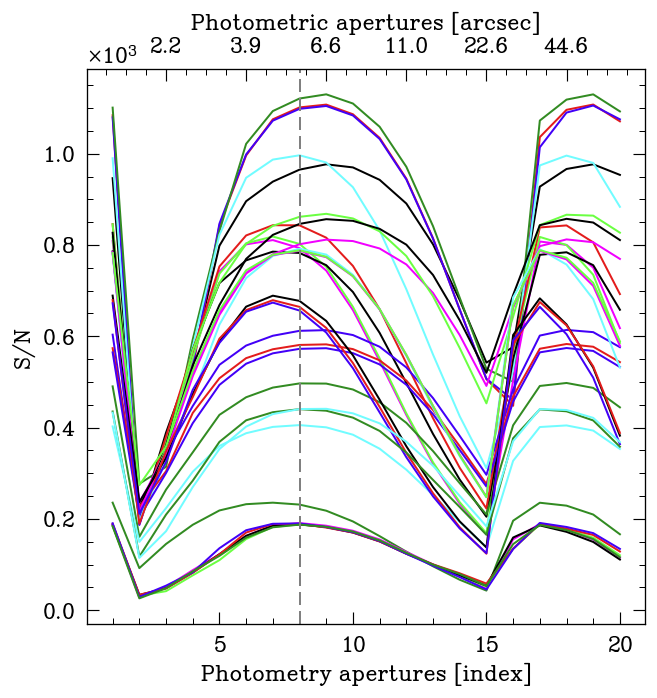

In [11]:
# S/N aperture
fig, ax1 = plt.subplots()

for i in range(len(S_N)):
    ax1.plot(pixel[0], S_N[i])

ax1.set_xlabel('Photometry apertures [index]')
ax1.set_ylabel('S/N')
#ax1.set_title('S/N vs aperture', fontweight='bold')

# Second axis
ax2 = ax1.twiny()

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(pixel[0][2::3])
ax2.set_xticklabels(PHOT_APERTURES[2::3])
ax2.set_xlabel('Photometric apertures [arcsec]')

# r0 for which S/N is maximum
ax1.axvline(x=8, color = 'gray', linestyle = '--')

plt.show()

In [12]:
PHOT_APERTURES

array([ 1.1,  1.6,  2.2,  2.8,  2.8,  3.9,  5.5,  6.1,  6.6,  7.7, 10.5,
       11. , 15.4, 16. , 22.6, 25.8, 31.9, 44.6, 63.3, 89.6])

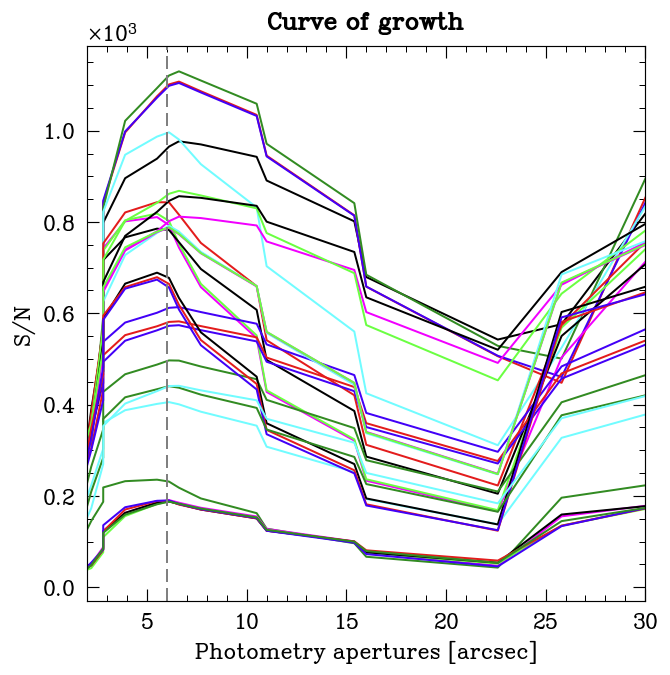

In [13]:
# S/N aperture
fig, ax1 = plt.subplots()

for i in range(len(S_N)):
    ax1.plot(PHOT_APERTURES, S_N[i])

ax1.set_xlabel('Photometry apertures [arcsec]')
ax1.set_ylabel('S/N')
#ax1.set_title('S/N vs aperture', fontweight='bold')

# r0 for which S/N is maximum
ax1.set_xlim(2, 30)
ax1.axvline(x=6, color = 'gray', linestyle = '--')
ax1.set_title('Curve of growth', fontweight='bold')

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/growth_curve.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
# Find the index value for which S/N is maximum for each curve
max_pixel = []

for i in range(len(S_N)):

    max_index = np.argmax(S_N[i])
    max_pixel.append(pixel[i][max_index])

best_index = int(np.round(np.median(max_pixel)) - 1) # minux 1 because Python start counting in 0
print('Median index for which S/N is higher:', np.round(np.median(max_pixel)))

Median index for which S/N is higher: 8.0


Thus, we should use `MAG_APER[8]` at array position = 8. 

## 3. Light curve

In this section, we are going to represent the light curve from the extracted and selected data. For this, we are going to use the `OBSDATE` column for time and the `MAG_APER[15]` columns for magnitudes from `gsdss_SN2023ixf` data. 

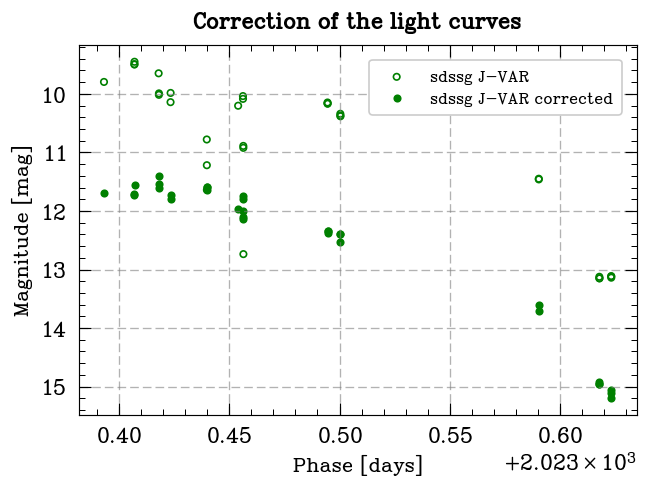

In [15]:
# Light curves
plt.figure(figsize=(6, 4))

plt.scatter(gsdss_SN2023ixf['OBSDATE'], gsdss_SN2023ixf['MAG_APER'][:,best_index], edgecolor='green', facecolor='none', label = 'sdssg J-VAR', s = 15)
plt.scatter(gsdss_SN2023ixf['OBSDATE'], gsdss_SN2023ixf['MAG_APER'][:,best_index] + gsdss_SN2023ixf['offset'], color = 'green', label = 'sdssg J-VAR corrected', s = 15)

#plt.errorbar(0,15,yerr=np.mean(e_mag_G),color="green",elinewidth=1,capsize=2)
#plt.errorbar(5,15,yerr=np.mean(e_mag_R),color="red",elinewidth=1,capsize=2)
#plt.errorbar(10,15,yerr=np.mean(e_mag_I),color="maroon",elinewidth=1,capsize=2)

plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Correction of the light curves', fontsize=16, fontweight='bold')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize = 11, frameon = True)

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/offset_correction.pdf', dpi=600, bbox_inches='tight')
plt.show()

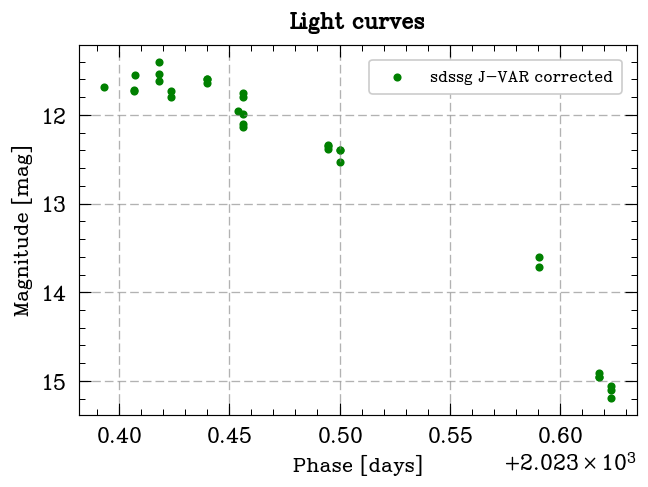

In [16]:
# Light curves
plt.figure(figsize=(6, 4))

plt.scatter(gsdss_SN2023ixf['OBSDATE'], gsdss_SN2023ixf['MAG_APER'][:,best_index] + gsdss_SN2023ixf['offset'], color = 'green', label = 'sdssg J-VAR corrected', s = 15)

#plt.errorbar(0,15,yerr=np.mean(e_mag_G),color="green",elinewidth=1,capsize=2)
#plt.errorbar(5,15,yerr=np.mean(e_mag_R),color="red",elinewidth=1,capsize=2)
#plt.errorbar(10,15,yerr=np.mean(e_mag_I),color="maroon",elinewidth=1,capsize=2)

plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light curves', fontsize=16, fontweight='bold')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize = 11, frameon = True)

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/light_curve_gSDSS_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

### 3.1. Comparison between Tx40 and J-VAR light curves

Now, we will compare the obatained light curve with Tx40 (`gsdss_Tx40`) telescope with the one obtained with J-VAR (`gsdss_SN2023ixf`). In this way, we can see the accuracy of the measures. 

In [17]:
# gsdss Tx40 data
gsdss_Tx40 = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Tx40/SN2023ixf.Gsdss_A6B3.0001.fot', format='ascii') # G sloan filter
col_names = ['image_name', 'jd', 'mag', 'e_mag', 'filter'] # change columns names
gsdss_Tx40.rename_columns(gsdss_Tx40.colnames, col_names)

In [18]:
# Functions to convert from decimal years to year/month/day/hour/min
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    fractional_year = decimal_year - year
    
    days_in_year = 365.25
    day_of_year = int(fractional_year * days_in_year)
    
    start_date = datetime(year, 1, 1)
    date = start_date + timedelta(days=day_of_year)
    
    return date

# Function to convert from year/month/day/hour/min to julian date
def date_to_julian_date(date):
    jd = jdcal.gcal2jd(date.year, date.month, date.day)
    return jd[1] + 2400000.5

# Convertion from gsdss_Tx40 data
gsdss_SN2023ixf_date = []
for i in range(len(gsdss_SN2023ixf['OBSDATE'])):
    gsdss_SN2023ixf_date.append(date_to_julian_date(decimal_year_to_date(gsdss_SN2023ixf['OBSDATE'][i])))

# Establish a t = 0
gsdss_Tx40_time = gsdss_Tx40['jd'] - min(gsdss_SN2023ixf_date)
gsdss_SN2023ixf_time = [i - min(gsdss_SN2023ixf_date) for i in gsdss_SN2023ixf_date]

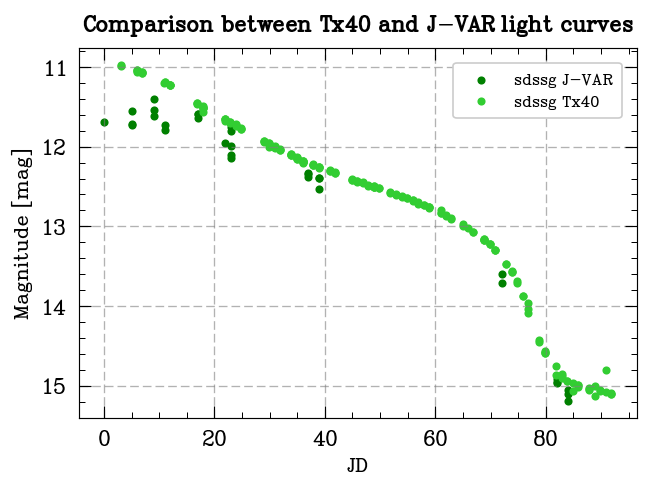

In [19]:
# Light curves
plt.figure(figsize=(6, 4))

mag_g_corrected = gsdss_SN2023ixf['MAG_APER'][:,best_index] + gsdss_SN2023ixf['offset']
plt.scatter(gsdss_SN2023ixf_time, mag_g_corrected, color = 'green', label = 'sdssg J-VAR', s = 15)

#plt.scatter(gsdss_SN2023ixf_time, gsdss_SN2023ixf['MAG_APER'][:,best_index], color = 'green', label = 'sdssg J-VAR', s = 15)
plt.scatter(gsdss_Tx40_time, gsdss_Tx40['mag'], color = 'limegreen', label = 'sdssg Tx40', s = 15)

#plt.errorbar(2460100,15,yerr=np.mean(gsdss_SN2023ixf['MAGERR_APER'][:,best_index]),color="green",elinewidth=1,capsize=2)
#plt.errorbar(2460100,15,yerr=np.mean(gsdss_Tx40['e_mag']),color="green",elinewidth=1,capsize=2)

plt.xlabel('JD', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title(r'Comparison between Tx40 and J$-$VAR light curves', fontsize=16, fontweight='bold')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize = 11, frameon = True)

plt.show()

### 3.2. Fit light curve

We are going to use the "[Bazin function](https://arxiv.org/pdf/1701.05689)" to fit the light curve of the supernovae.

\begin{equation}
    f(t) = A \cdot \frac{e^{-(t-t_0)/\tau_{fall}}}{1+e^{(t-t_0)/\tau_{rise}}} + B
\end{equation}

We have to fit the A, B, $\tau_{fall}$, $\tau_{rise}$ and $t_0$ parameters. For this, we are going to apply the `lmfit` package from Python. First, we report the fit results in a cell. See this [paper](https://arxiv.org/pdf/1701.05689) to understand de physics of the parameters.

In [20]:
# Function to Tit (light curve)
def light_curve(t, A, B, tau_fall, tau_rise, t_0):
    return A * (np.exp(-(t - t_0) / tau_fall)) / (1 + np.exp((t - t_0) / tau_rise)) + B

# Models
model = Model(light_curve)

# Initial Conditions
params_G_JVAR = Parameters()
params_G_JVAR.add('A', value=-2, max=20, min=-20)
params_G_JVAR.add('B', value=15, min=-20, max=20)
params_G_JVAR.add('tau_fall', value=138., min=1, max=100)
params_G_JVAR.add('tau_rise', value=4., min=1, max=150)
params_G_JVAR.add('t_0', value=75., min=1, max=150)

params_G_Tx40 = model.make_params(A=1, B=1, tau_fall=1, tau_rise=1, t_0=1)

# Fit Parameters 
'''
gsdss_SN2023ixf_corrected = gsdss_SN2023ixf['MAG_APER'][:,best_index] + gsdss_SN2023ixf['offset']
result_G_JVAR = model.fit(gsdss_SN2023ixf_corrected, params_G_JVAR, t=gsdss_SN2023ixf_time,
                          weights = 1/gsdss_SN2023ixf['MAGERR_APER'][:,best_index],
                          method='emcee', fit_kws={'steps': 6000, 'nwalkers': 150, 'burn': 3000, 'thin': 20})
'''

result_G_Tx40 = model.fit(gsdss_Tx40['mag'], params_G_Tx40, t=gsdss_Tx40_time,
                          weights = 1/gsdss_Tx40['e_mag'])

#Results
print(result_G_Tx40.fit_report())

[[Model]]
    Model(light_curve)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 295
    # data points      = 190
    # variables        = 5
    chi-square         = 109.685037
    reduced chi-square = 0.59289209
    Akaike info crit   = -94.3881119
    Bayesian info crit = -78.1529916
    R-squared          = 0.55962237
[[Variables]]
    A:        -1.88719637 +/- 0.01152084 (0.61%) (init = 1)
    B:         15.0827479 +/- 0.01055158 (0.07%) (init = 1)
    tau_fall:  93.3918540 +/- 0.66464234 (0.71%) (init = 1)
    tau_rise:  2.87253258 +/- 0.06260205 (2.18%) (init = 1)
    t_0:       77.2186308 +/- 0.07917572 (0.10%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, tau_fall)        = -0.9069
    C(A, B)               = -0.8353
    C(B, t_0)             = +0.6294
    C(A, tau_rise)        = -0.6247
    C(B, tau_fall)        = +0.5967
    C(B, tau_rise)        = +0.5663
    C(tau_fall, tau_rise) = +0.5557
    C(tau_rise, t_0)      =

In [21]:
# Errors of the fits
#params_G_JVAR = result_G_JVAR.params
params_G_Tx40 = result_G_Tx40.params

#errors_G_JVAR = {key: value.stderr for key, value in params_G_JVAR.items()}
errors_R_Tx40 = {key: value.stderr for key, value in params_G_Tx40.items()}

# Function to obtain errors
def get_error_bands(params, x, errors, model_func):
    y_fit = model_func(x, **params)
    y_errs = {k: v * np.abs(y_fit) for k, v in errors.items()}  # Error propagado
    return y_fit - y_errs['A'], y_fit + y_errs['A']

# Shadows -- erros
#x_fit_G_JVAR = np.linspace(min(gsdss_SN2023ixf_time), max(gsdss_SN2023ixf_time), 1000)
#y_fit_G_JVAR = light_curve(x_fit_G_JVAR, **result_G_JVAR.params.valuesdict())
#y_lower_G_JVAR, y_upper_G_JVAR = get_error_bands(result_G_JVAR.params.valuesdict(), x_fit_G_JVAR, errors_G_JVAR, light_curve)

x_fit_G_Tx40 = np.linspace(min(gsdss_Tx40_time), max(gsdss_Tx40_time), 1000)
y_fit_G_Tx40 = light_curve(x_fit_G_Tx40, **result_G_Tx40.params.valuesdict())
y_lower_G_Tx40, y_upper_G_Tx40 = get_error_bands(result_G_Tx40.params.valuesdict(), x_fit_G_Tx40, errors_R_Tx40, light_curve)

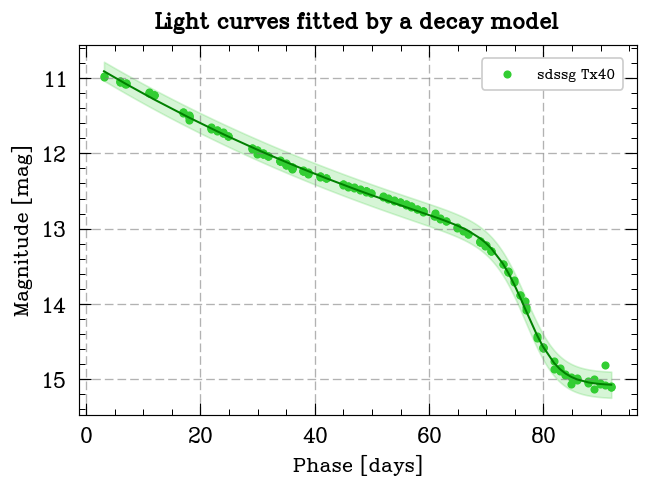

In [22]:
# Plot results
plt.figure(figsize=(6, 4))

#plt.scatter(gsdss_SN2023ixf_time, gsdss_SN2023ixf_corrected, color = 'green', label = 'sdssg J-VAR', s = 15) # g JVAR band
#plt.plot(gsdss_SN2023ixf_time, result_G_JVAR.best_fit, 'green', linestyle = '-') # g band fit
#plt.fill_between(x_fit_G_JVAR, y_lower_G_JVAR, y_upper_G_JVAR, color='green', alpha=0.2) # shadow error

plt.scatter(gsdss_Tx40_time, gsdss_Tx40['mag'], color = 'limegreen', label = 'sdssg Tx40', s = 15) # g Tx40 band
plt.plot(gsdss_Tx40_time, result_G_Tx40.best_fit, 'green', linestyle = '-') # g band fit
plt.fill_between(x_fit_G_Tx40, y_lower_G_Tx40, y_upper_G_Tx40, color='limegreen', alpha=0.2) # shadow error

plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light curves fitted by a decay model', fontsize=16, fontweight='bold')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize = 10, frameon = True)

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/lmfit_light_curve_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

We could not do the fit with JVAR in g-band. We will try it again by using J-PLUS instead of SDSS, but in another jupyter notebook.

In [23]:
# Ejectuoon Time
b = time.time()
print(np.round((b-a)/60,2),'min of execution')

0.82 min of execution
